<a href="https://colab.research.google.com/github/WhiteFox-Lugh/Pratice-TextAnalysis/blob/master/exercise2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 情報システム論実習　テキスト分析　課題2A

## import

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections
from gensim import models
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [2]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("reuters")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### データを取得

今回は nltk の reuters を使用する

In [3]:
from nltk.corpus import reuters as corpus

### 全 document 数の確認

In [4]:
len(corpus.fileids())

10788

### 前から k 文書とってくる

In [5]:
k = 2000
docs = [corpus.words(fileid) for fileid in corpus.fileids()[:k]]
tag_arr = corpus.fileids()[:k]
# print(tag_arr)

### カテゴリーのチェック

最初の5文書のカテゴリー

In [6]:
for i in range(5):
  t = tag_arr[i]
  print(corpus.categories(t))

['trade']
['grain']
['crude', 'nat-gas']
['corn', 'grain', 'rice', 'rubber', 'sugar', 'tin', 'trade']
['palm-oil', 'veg-oil']


文書名 -> カテゴリーのディクショナリを作成

In [7]:
docs_category = {}
for i in range(len(corpus.fileids()[:k])):
  cat = tag_arr[i]
  docs_category[cat] = corpus.categories(cat)

## 前処理

### nltkのストップワードリスト

In [8]:
en_stop = nltk.corpus.stopwords.words('english')

In [9]:
en_stop= ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"] + ["said","say","u","v","mln","ct","net","dlrs","tonne","pct","shr","nil","company","lt","share","year","billion","price"] + en_stop

### 前処理関数の作成

In [10]:
from nltk.corpus import wordnet as wn #lemmatize関数のためのimport

def preprocess_word(word, stopwordset):
    
    #1.make words lower ex: Python =>python
    word=word.lower()

    #2. remove number
    try:
      word = int(word)
      return None
    except:
      pass
    
    #3.remove "," and "."
    if word in [",","."]:
        return None
    
    #4.remove stopword  ex: the => (None) 
    if word in stopwordset:
        return None
    
    #5.lemmatize  ex: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma
    

def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

### 前処理の結果を出力してみる

### 前処理前

In [11]:
print(docs[1][:100]) 

['CHINA', 'DAILY', 'SAYS', 'VERMIN', 'EAT', '7', '-', '12', 'PCT', 'GRAIN', 'STOCKS', 'A', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume', 'between', 'seven', 'and', '12', 'pct', 'of', 'China', "'", 's', 'grain', 'stocks', ',', 'the', 'China', 'Daily', 'said', '.', 'It', 'also', 'said', 'that', 'each', 'year', '1', '.', '575', 'mln', 'tonnes', ',', 'or', '25', 'pct', ',', 'of', 'China', "'", 's', 'fruit', 'output', 'are', 'left', 'to', 'rot', ',', 'and', '2', '.', '1', 'mln', 'tonnes', ',', 'or', 'up', 'to', '30', 'pct', ',', 'of', 'its', 'vegetables', '.', 'The', 'paper', 'blamed', 'the', 'waste', 'on', 'inadequate', 'storage', 'and', 'bad', 'preservation', 'methods', '.', 'It', 'said', 'the', 'government']


### 前処理後

In [12]:
print(preprocess_documents(docs)[1][:100])

['china', 'daily', 'vermin', 'eat', 'grain', 'stocks', 'survey', 'province', 'seven', 'city', 'show', 'vermin', 'consume', 'seven', 'china', 'grain', 'stocks', 'china', 'daily', 'also', 'china', 'fruit', 'output', 'left', 'rot', 'vegetable', 'paper', 'blame', 'waste', 'inadequate', 'storage', 'bad', 'preservation', 'method', 'government', 'launch', 'national', 'programme', 'reduce', 'waste', 'calling', 'improve', 'technology', 'storage', 'preservation', 'greater', 'production', 'additive', 'paper', 'give', 'details']


## クラスタリング

### doc2vec の準備

In [13]:
pre_docs=preprocess_documents(docs)
labeled_sentence = [TaggedDocument(words = pre_docs[n], tags = [tag_arr[n]]) 
                    for n in range(k)]
# print(labeled_sentence)

In [14]:
# モデルの定義
# dm : 1 なら PV-DM を使い、0 なら PV-DBOW を使う
# vector_size : 特徴ベクトルの次元数
# windows : 前後何単語とるか
# min_count : total frequency がこれ未満なら単語を無視する（今回は無視しない）
# alpha : 学習率
model = Doc2Vec(documents = labeled_sentence, dm = 1, vector_size = 50,
                windows = 5, min_count = 1, alpha = 0.0015)

### fitする

In [15]:
# document size の再確認
print(len(pre_docs))

# k-means の入力にする
vecs = [model.docvecs[i] for i in range(len(model.docvecs))]
doc_prefix = [(pre_docs[i][0] + " " + pre_docs[i][1] + " ...") for i in range(len(model.docvecs))]

print(tag_arr[0])
print(doc_prefix[0])
print(vecs[0])

2000
test/14826
asian exporter ...
[ 5.5111465e-03 -1.1001383e-03  5.6034802e-03 -7.5283386e-03
 -7.0022563e-03 -6.5143024e-05  7.3645124e-03  2.1543032e-03
  2.0130246e-03 -9.8005533e-03 -5.7533383e-03 -9.3139842e-04
  4.9666446e-03 -3.0639933e-03  6.8418183e-03  8.4789405e-03
 -3.0632406e-03 -3.3081397e-03  9.2665926e-03 -2.5089013e-03
  3.9834911e-03  8.7644337e-03 -8.2705775e-03  6.1125183e-03
  1.7433481e-03 -9.7762104e-03 -1.3735319e-03  8.2535474e-03
  2.1468285e-03  6.3641975e-03  4.1192067e-03 -1.9854556e-03
 -9.3625626e-03  7.3481929e-03  7.3457966e-03  2.8524294e-03
  6.6843373e-04  5.0238078e-03  3.0948948e-03 -8.3422771e-04
  2.7255120e-04  5.4439143e-03  5.1590643e-04  8.6444085e-03
  8.0645401e-03  4.9106725e-03 -5.8595175e-03  8.7461481e-03
  8.1993872e-03 -4.4672922e-03]


### tf-idf

In [16]:
pre_docs=preprocess_documents(docs)
pre_docs=[" ".join(doc) for doc in pre_docs]
print(pre_docs[0])

vectorizer = TfidfVectorizer(max_features=50, token_pattern=u'(?u)\\b\\w+\\b' )
tf_idf = vectorizer.fit_transform(pre_docs)

asian exporter fear damage japan rift mounting trade friction japan raise fear among many asia exporting nation row could inflict far reaching economic damage businessmen official tell reuter correspondent asian capital move japan might boost protectionist sentiment lead curb american import product exporter conflict would hurt long run short term tokyo loss might gain impose tariff import japanese electronics good april retaliation japan allege failure stick pact sell semiconductor world market cost unofficial japanese estimate put impact tariff spokesman major electronics firm would virtually halt export product hit new tax able business spokesman leading japanese electronics firm matsushita electric industrial co ltd mc >. tariff remain place length time beyond month mean complete erosion export good subject tariff tom murtha stock analyst tokyo office broker james capel co >. taiwan businessmen official also worry aware seriousness threat japan serve warning us senior taiwanese tra

### K-means
### kmeansの設定

In [17]:
def fun_kmeans(n, v_input):
  # k-means definition
  # n_clusters : クラスタ数
  km = KMeans(n_clusters = n, max_iter = 300, n_init = 10,
              init = 'k-means++', random_state = 0)
  ret = km.fit_predict(v_input)
  ret2 = km.inertia_
  return ret, ret2

In [18]:
def cluster_counter(n, v_len, clusters_res):
  # クラスタごとのカウント
  cnt = np.zeros(n)

  for j in range(v_len):
    c = clusters_res[j]
    cnt[c] += 1

  print(cnt)
  return

In [19]:
def show_category(n, cls_res):
  for j in range(n):
    print("Cluster num : " + str(j))
    l = []
    for doc, cls in zip(tag_arr, cls_res):
      if not cls == j:
        continue
      category_arr = docs_category[doc]
      l.extend(category_arr)
    c = collections.Counter(l)
    print(c)
  return

### k-means の k を様々な値にして回す

#### doc2vec

In [20]:
x = np.empty(0)
y = np.empty(0)

for i in range(1, 16, 1):
  print("Cluster Nums -> " + str(i))
  # モデル定義 / fit
  clusters, sse = fun_kmeans(i, vecs)

  # クラスタリング結果表示（数）
  cluster_counter(i, len(vecs), clusters)

  # タグの表示
  show_category(i, clusters)

  # SSE の表示
  print("Distortion : %.5f"% sse)

  # plot 用
  x = np.append(x, i)
  y = np.append(y, sse)

  print("==========================\n")

Cluster Nums -> 1
[2000.]
Cluster num : 0
Counter({'earn': 633, 'acq': 490, 'grain': 118, 'money-fx': 108, 'crude': 105, 'interest': 91, 'trade': 89, 'wheat': 58, 'ship': 45, 'corn': 44, 'dlr': 37, 'oilseed': 34, 'gnp': 32, 'sugar': 30, 'money-supply': 30, 'veg-oil': 27, 'nat-gas': 25, 'soybean': 23, 'bop': 23, 'gold': 22, 'cpi': 22, 'rice': 20, 'livestock': 19, 'alum': 19, 'coffee': 18, 'jobs': 17, 'meal-feed': 17, 'reserves': 16, 'copper': 15, 'gas': 15, 'cocoa': 15, 'carcass': 14, 'cotton': 14, 'barley': 13, 'lead': 12, 'iron-steel': 12, 'tin': 11, 'soy-oil': 11, 'yen': 11, 'strategic-metal': 11, 'orange': 11, 'soy-meal': 11, 'zinc': 10, 'sorghum': 10, 'pet-chem': 10, 'wpi': 10, 'palm-oil': 9, 'ipi': 8, 'fuel': 8, 'rubber': 7, 'platinum': 7, 'income': 7, 'rapeseed': 6, 'silver': 6, 'lumber': 5, 'heat': 5, 'oat': 5, 'groundnut': 4, 'hog': 4, 'rape-oil': 3, 'potato': 3, 'lei': 3, 'sunseed': 2, 'sun-oil': 2, 'retail': 2, 'cotton-oil': 2, 'tea': 2, 'coconut-oil': 2, 'dmk': 2, 'naphtha':

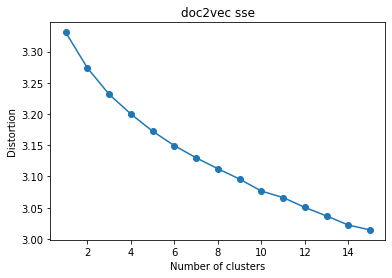

In [21]:
# エルボー法の plot
plt.plot(x, y, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("doc2vec sse")
plt.show()

#### tf-idf

In [22]:
x = np.empty(0)
y = np.empty(0)

for i in range(1, 16, 1):
  print("Cluster Nums -> " + str(i))
  # モデル定義 / fit
  clusters, sse = fun_kmeans(i, tf_idf)

  # クラスタリング結果表示（数）
  cluster_counter(i, np.shape(tf_idf)[0], clusters)

  # タグの表示
  show_category(i, clusters)

  # SSE の表示
  print("Distortion : %.5f"% sse)

  # plot 用
  x = np.append(x, i)
  y = np.append(y, sse)

  print("==========================\n")

Cluster Nums -> 1
[2000.]
Cluster num : 0
Counter({'earn': 633, 'acq': 490, 'grain': 118, 'money-fx': 108, 'crude': 105, 'interest': 91, 'trade': 89, 'wheat': 58, 'ship': 45, 'corn': 44, 'dlr': 37, 'oilseed': 34, 'gnp': 32, 'sugar': 30, 'money-supply': 30, 'veg-oil': 27, 'nat-gas': 25, 'soybean': 23, 'bop': 23, 'gold': 22, 'cpi': 22, 'rice': 20, 'livestock': 19, 'alum': 19, 'coffee': 18, 'jobs': 17, 'meal-feed': 17, 'reserves': 16, 'copper': 15, 'gas': 15, 'cocoa': 15, 'carcass': 14, 'cotton': 14, 'barley': 13, 'lead': 12, 'iron-steel': 12, 'tin': 11, 'soy-oil': 11, 'yen': 11, 'strategic-metal': 11, 'orange': 11, 'soy-meal': 11, 'zinc': 10, 'sorghum': 10, 'pet-chem': 10, 'wpi': 10, 'palm-oil': 9, 'ipi': 8, 'fuel': 8, 'rubber': 7, 'platinum': 7, 'income': 7, 'rapeseed': 6, 'silver': 6, 'lumber': 5, 'heat': 5, 'oat': 5, 'groundnut': 4, 'hog': 4, 'rape-oil': 3, 'potato': 3, 'lei': 3, 'sunseed': 2, 'sun-oil': 2, 'retail': 2, 'cotton-oil': 2, 'tea': 2, 'coconut-oil': 2, 'dmk': 2, 'naphtha':

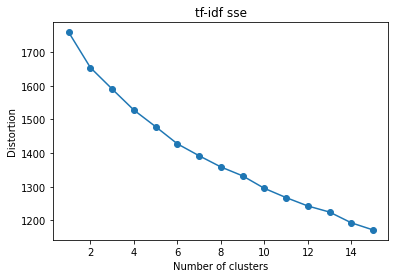

In [23]:
# エルボー法の plot
plt.plot(x, y, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("tf-idf sse")
plt.show()